# Import bibliotek

In [39]:
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import operator as op
import itertools as it
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Korpus dokumentów

In [40]:
corpus_dir = ("./my_original_summaries")
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
file_names = corpus.fileids()
file_names

['Historia_Polski.txt',
 'Ladowanie_na_Ksiezycu.txt',
 'Rewolucja_Internetu.txt',
 'Sztuczna_Inteligencja.txt',
 'Zmiany_Klimatu.txt']

# Wstępne przygotowanie dokumentów

In [41]:
documents = {}
for file in file_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent = 4, ensure_ascii = False)) 

{
    "Historia_Polski.txt": "Historia Polski jest bogata i pełna przełomowych wydarzeń. W średniowieczu krajem rządzili Piastowie i Jagiellonowie. Unia z Litwą stworzyła jedno z największych państw Europy. W XVIII wieku Polska utraciła niepodległość w wyniku rozbiorów dokonanych przez sąsiadów. Po I wojnie światowej kraj odzyskał suwerenność w 1918 roku. II wojna światowa przyniosła ogromne straty i cierpienia. Po wojnie Polska znalazła się w strefie wpływów ZSRR. Ruch Solidarność odegrał kluczową rolę w obaleniu komunizmu w latach 80. W XXI wieku Polska przystąpiła do Unii Europejskiej i NATO. Dzieje kraju kształtują tożsamość i dumę narodową Polaków.",
    "Ladowanie_na_Ksiezycu.txt": "Pierwsze lądowanie człowieka na Księżycu w 1969 roku było przełomowym wydarzeniem w historii ludzkości. Neil Armstrong i Buzz Aldrin jako pierwsi stanęli na powierzchni Księżyca, podczas gdy Michael Collins czekał na orbicie. Misja Apollo 11 była efektem lat badań naukowych i postępu technologicznego.

In [42]:
stoplist_file = open("./my_stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'ależ',
 'ani',
 'aż',
 'bardziej',
 'bardzo',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bynajmniej',
 'być',
 'był',
 'była',
 'było',
 'były',
 'będzie',
 'będą',
 'cali',
 'cała',
 'cały',
 'ci',
 'cię',
 'ciebie',
 'co',
 'cokolwiek',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokąd',
 'dość',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dziś',
 'dzisiaj',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzieś',
 'go',
 'i',
 'ich',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'iz',
 'ja',
 'jak',
 'jaka',
 'jakby',
 'jaki',
 'jakichś',
 'jakie',
 'jakiś',
 'jakiż',
 'jakkolwiek',
 'jako',
 'jakoś',
 'je',
 'jeden',
 'jedna',
 'jedno',
 'jednak',
 'jednakże',
 'jego',
 'jej',
 'jemu',
 'jest',
 'jestem',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'każdy',
 'kiedy',
 'kilka',
 'kimś',
 'kto',
 'ktokolwiek',
 'ktoś',
 'która',
 'które',
 

In [43]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [44]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))  

{
    "Historia_Polski.txt": "historia polski bogaty pełny przełomowy wydarzenie w średniowiecze kraj rządzić piast Jagiellon unia z litwa stworzyć z duży państwo europ w XVIII wiek polski utracić niepodległość w wynik rozbiór dokonany przez sąsiad po wojna światowy krajać odzyskać suwerenność w rok ii wojna światowy przynieść ogromny strata cierpienie po wojna polski znaleźć się w strefa wpływ ZSRR ruch solidarność odegrać kluczowy rola w obalenie komunizm w rok w XXI wiek polski przystąpić unia europejski Nata dziać kraj kształtować tożsamość duma narodowy polak",
    "Ladowanie_na_Ksiezycu.txt": "pierwszy lądowanie człowiek na księżyc w rok przełomowy wydarzenie w historia ludzkość neil Armstrong buzz aldrin pierwszy stanąć na powierzchnia księżyc podczas Michael Collins czekało na orbita misja apollo efekt rok badanie naukowy postęp technologiczny milion człowiek na świat śledzić to wydarzyć na żywo w telewizja astronauta zebrać próbka księżycowy grunt przeprowadzić eksperyment pos

# Utworzenie macierzy częstości 

In [45]:
docs = pd.DataFrame.from_dict(documents, orient = 'index')
docs.columns = ['content']
docs

,content
Historia_Polski.txt,historia polski bogaty pełny przełomowy wydarz...
Ladowanie_na_Ksiezycu.txt,pierwszy lądowanie człowiek na księżyc w rok p...
Rewolucja_Internetu.txt,wynaleźć internet całkowicie zmienić sposób ko...
Sztuczna_Inteligencja.txt,sztuczny inteligencja coraz zmieniać różny asp...
Zmiany_Klimatu.txt,zmiana klimat to z poważny wyzwanie współczesn...


In [46]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [3, 0, 1, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], shape=(5, 313))

In [47]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09341713, 0.        , ..., 0.        , 0.        ,
        0.09341713],
       [0.        , 0.        , 0.        , ..., 0.08644729, 0.        ,
        0.        ],
       [0.29703628, 0.        , 0.09901209, ..., 0.15976466, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09891189,
        0.        ]], shape=(5, 313))

# Chmury tagów

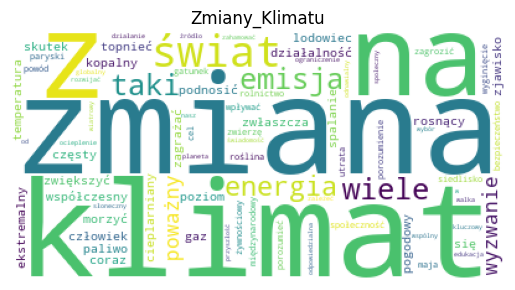

In [48]:
wordcloud = WordCloud(background_color = "white", max_words = 5000, contour_width = 3, contour_color = "steelblue")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(index.replace(".txt", ""))
    plt.savefig("./wordclouds/{}".format(index.replace(".txt", ".png")))

# Topic modelling

In [49]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis = "both", which = "major", labelsize = 20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize = 40)

    plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
    plt.savefig(f"./my_topics/{title}.png")

In [50]:
n_components = 3
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
size = [1, 3]

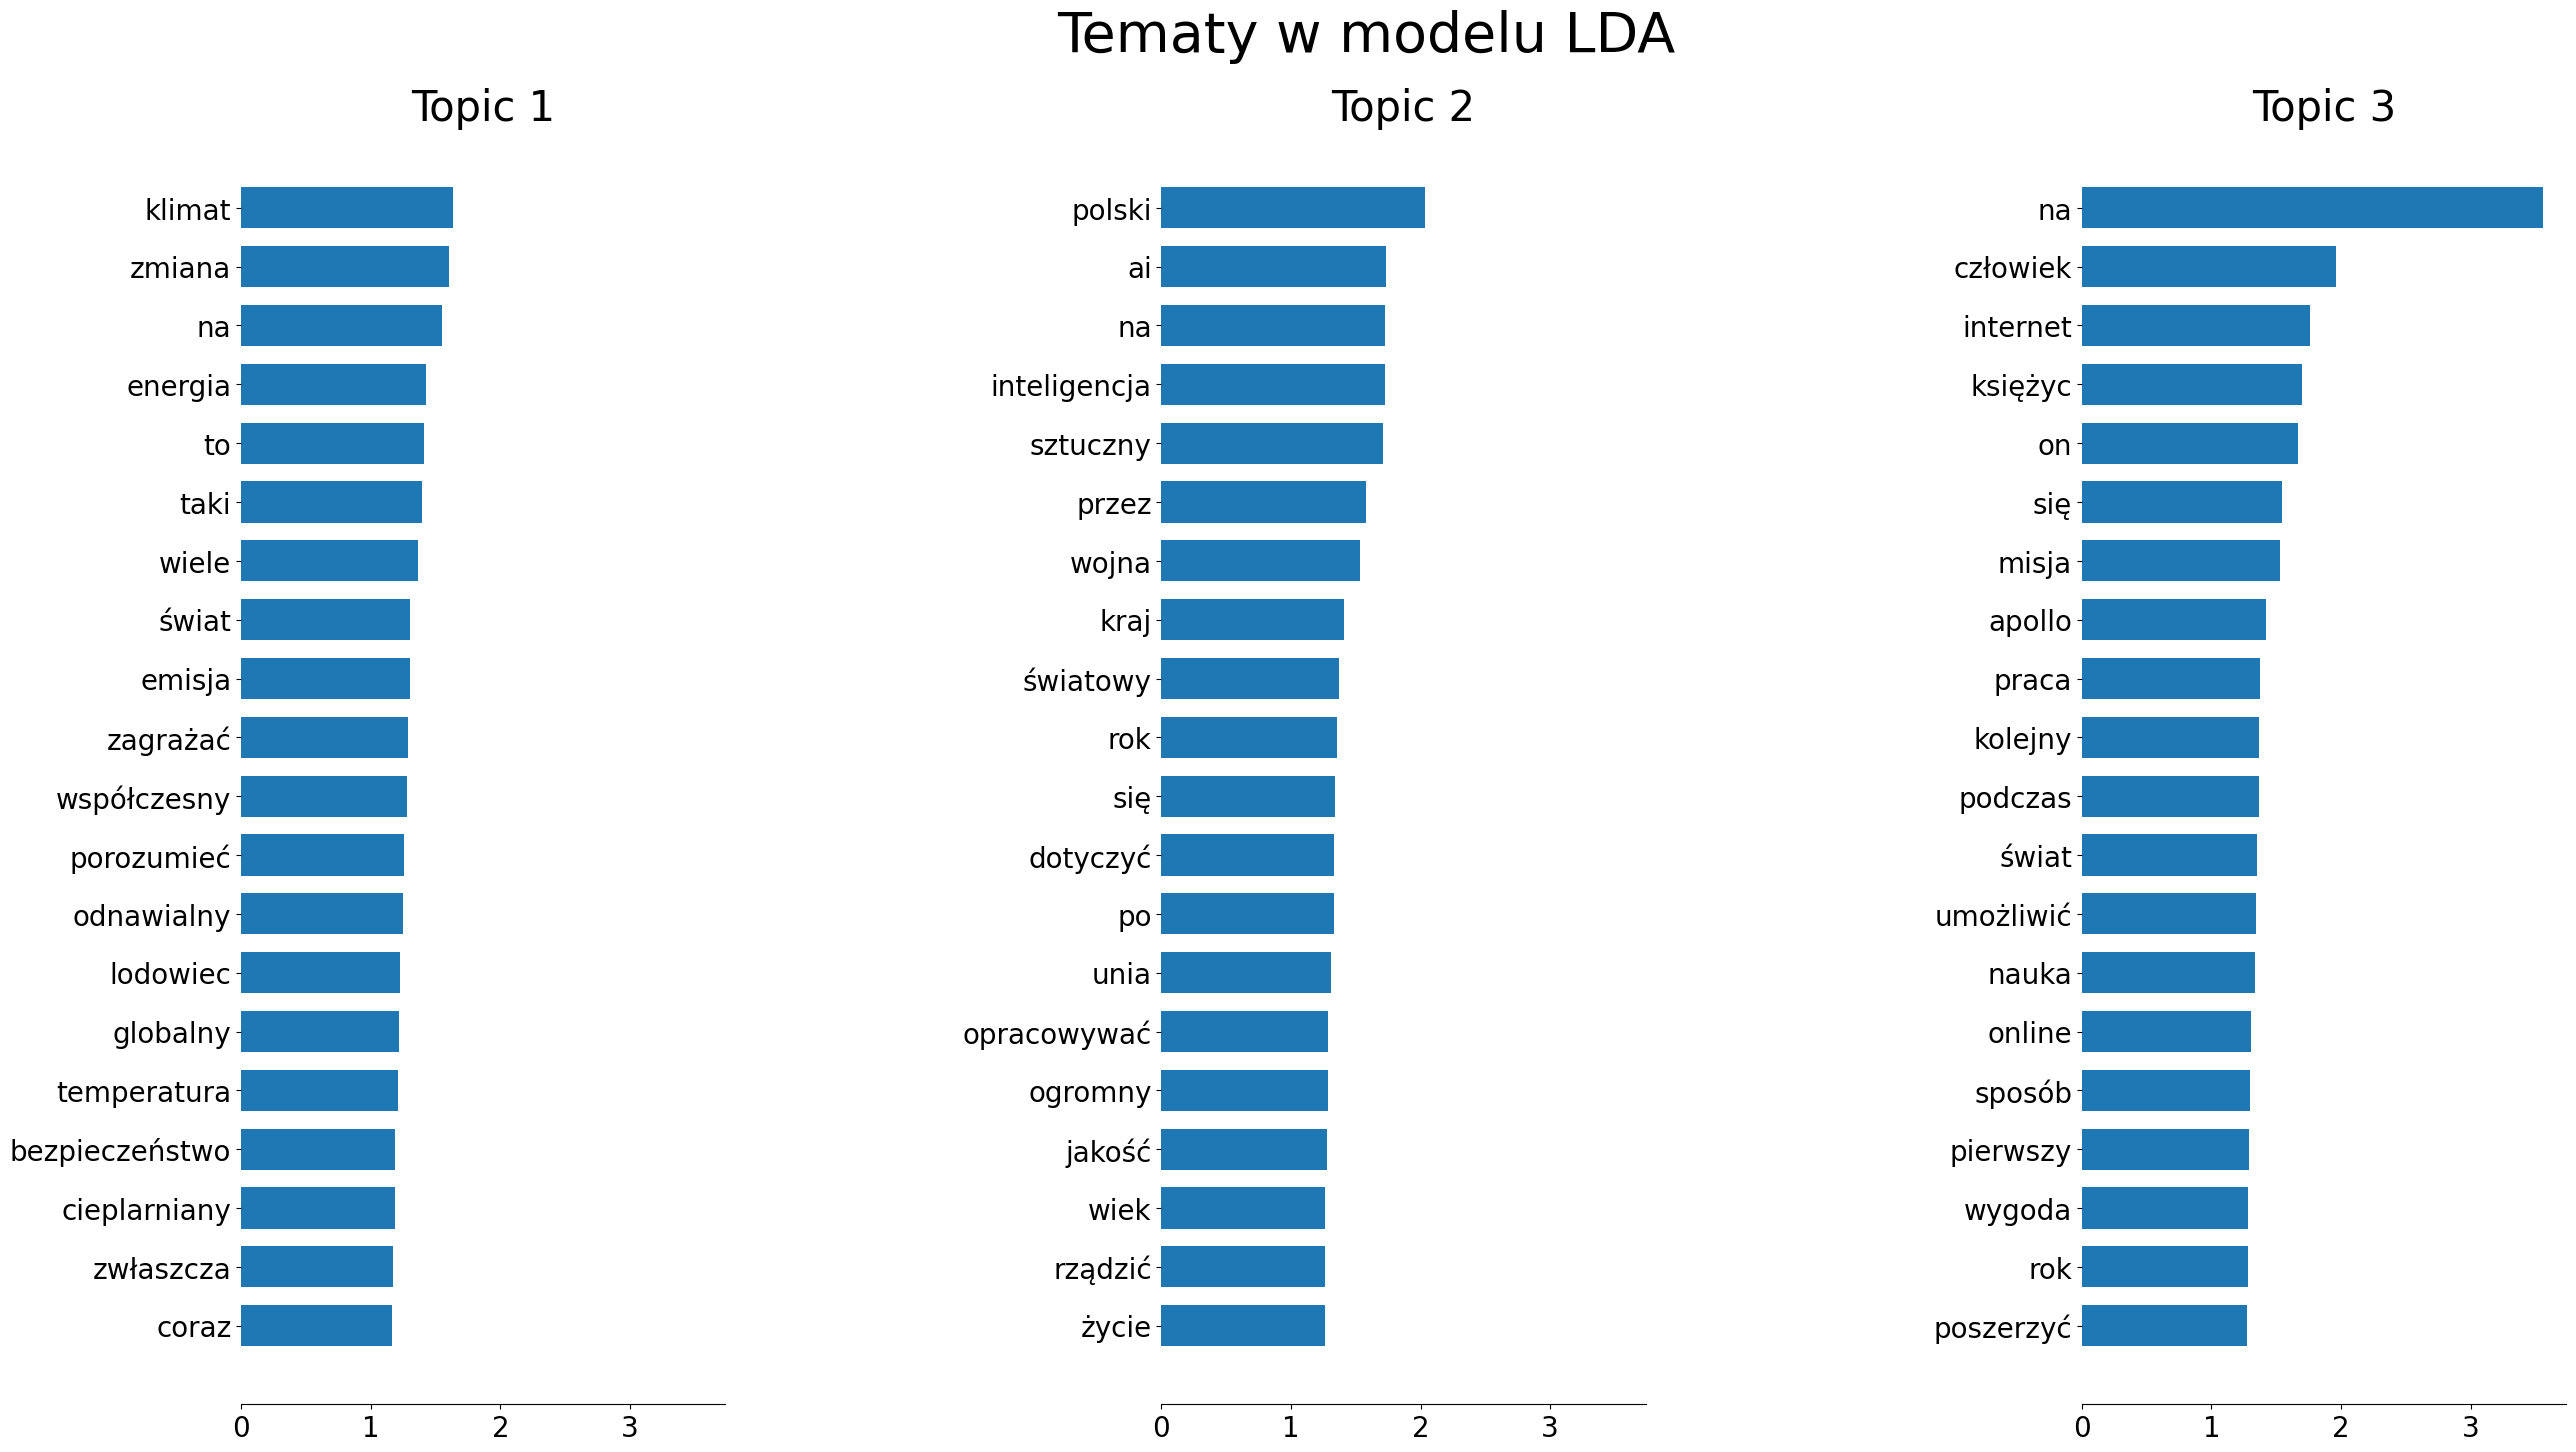

In [51]:
lda = LatentDirichletAllocation(
    n_components = n_components, 
    max_iter = 5, 
    learning_method = 'online', 
    learning_offset = 50,
    random_state = 0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", size)

c:\Users\adrwl\TextMiningS11-main\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


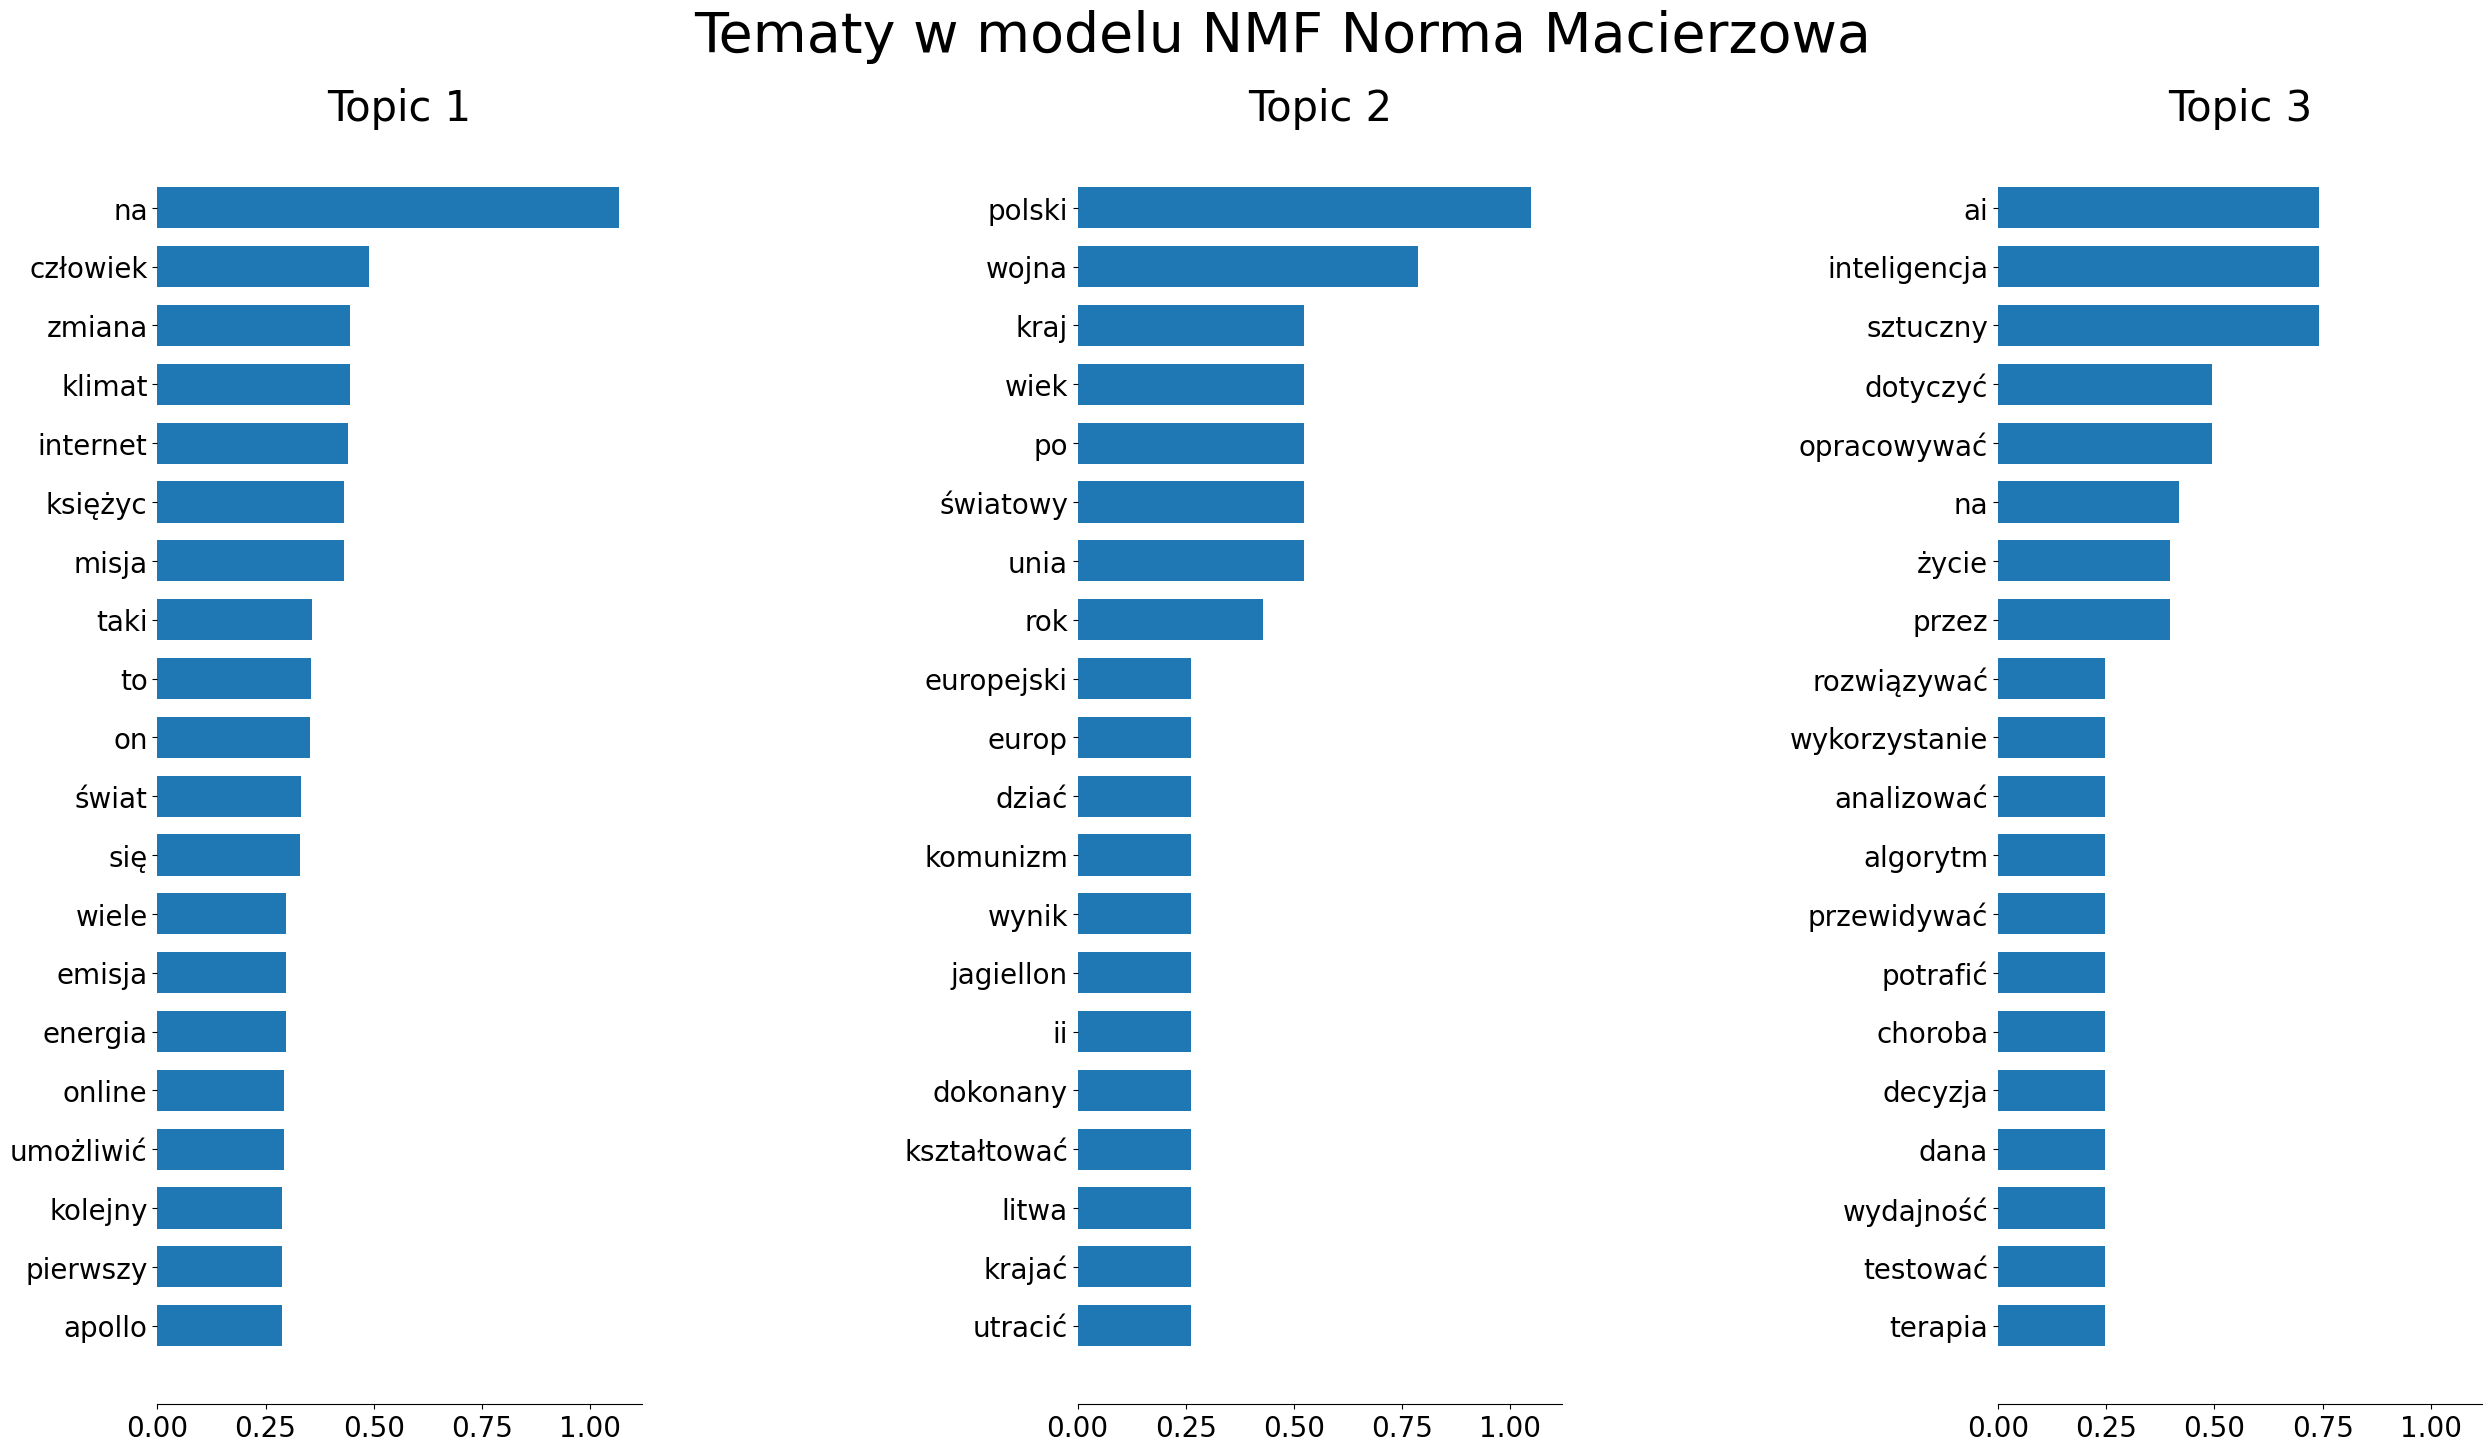

In [52]:
nmf_fm = NMF(
    n_components=n_components,
    random_state = 1, 
    alpha_H = .00005,
    alpha_W = .00005,
    l1_ratio = .5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF Norma Macierzowa", size)

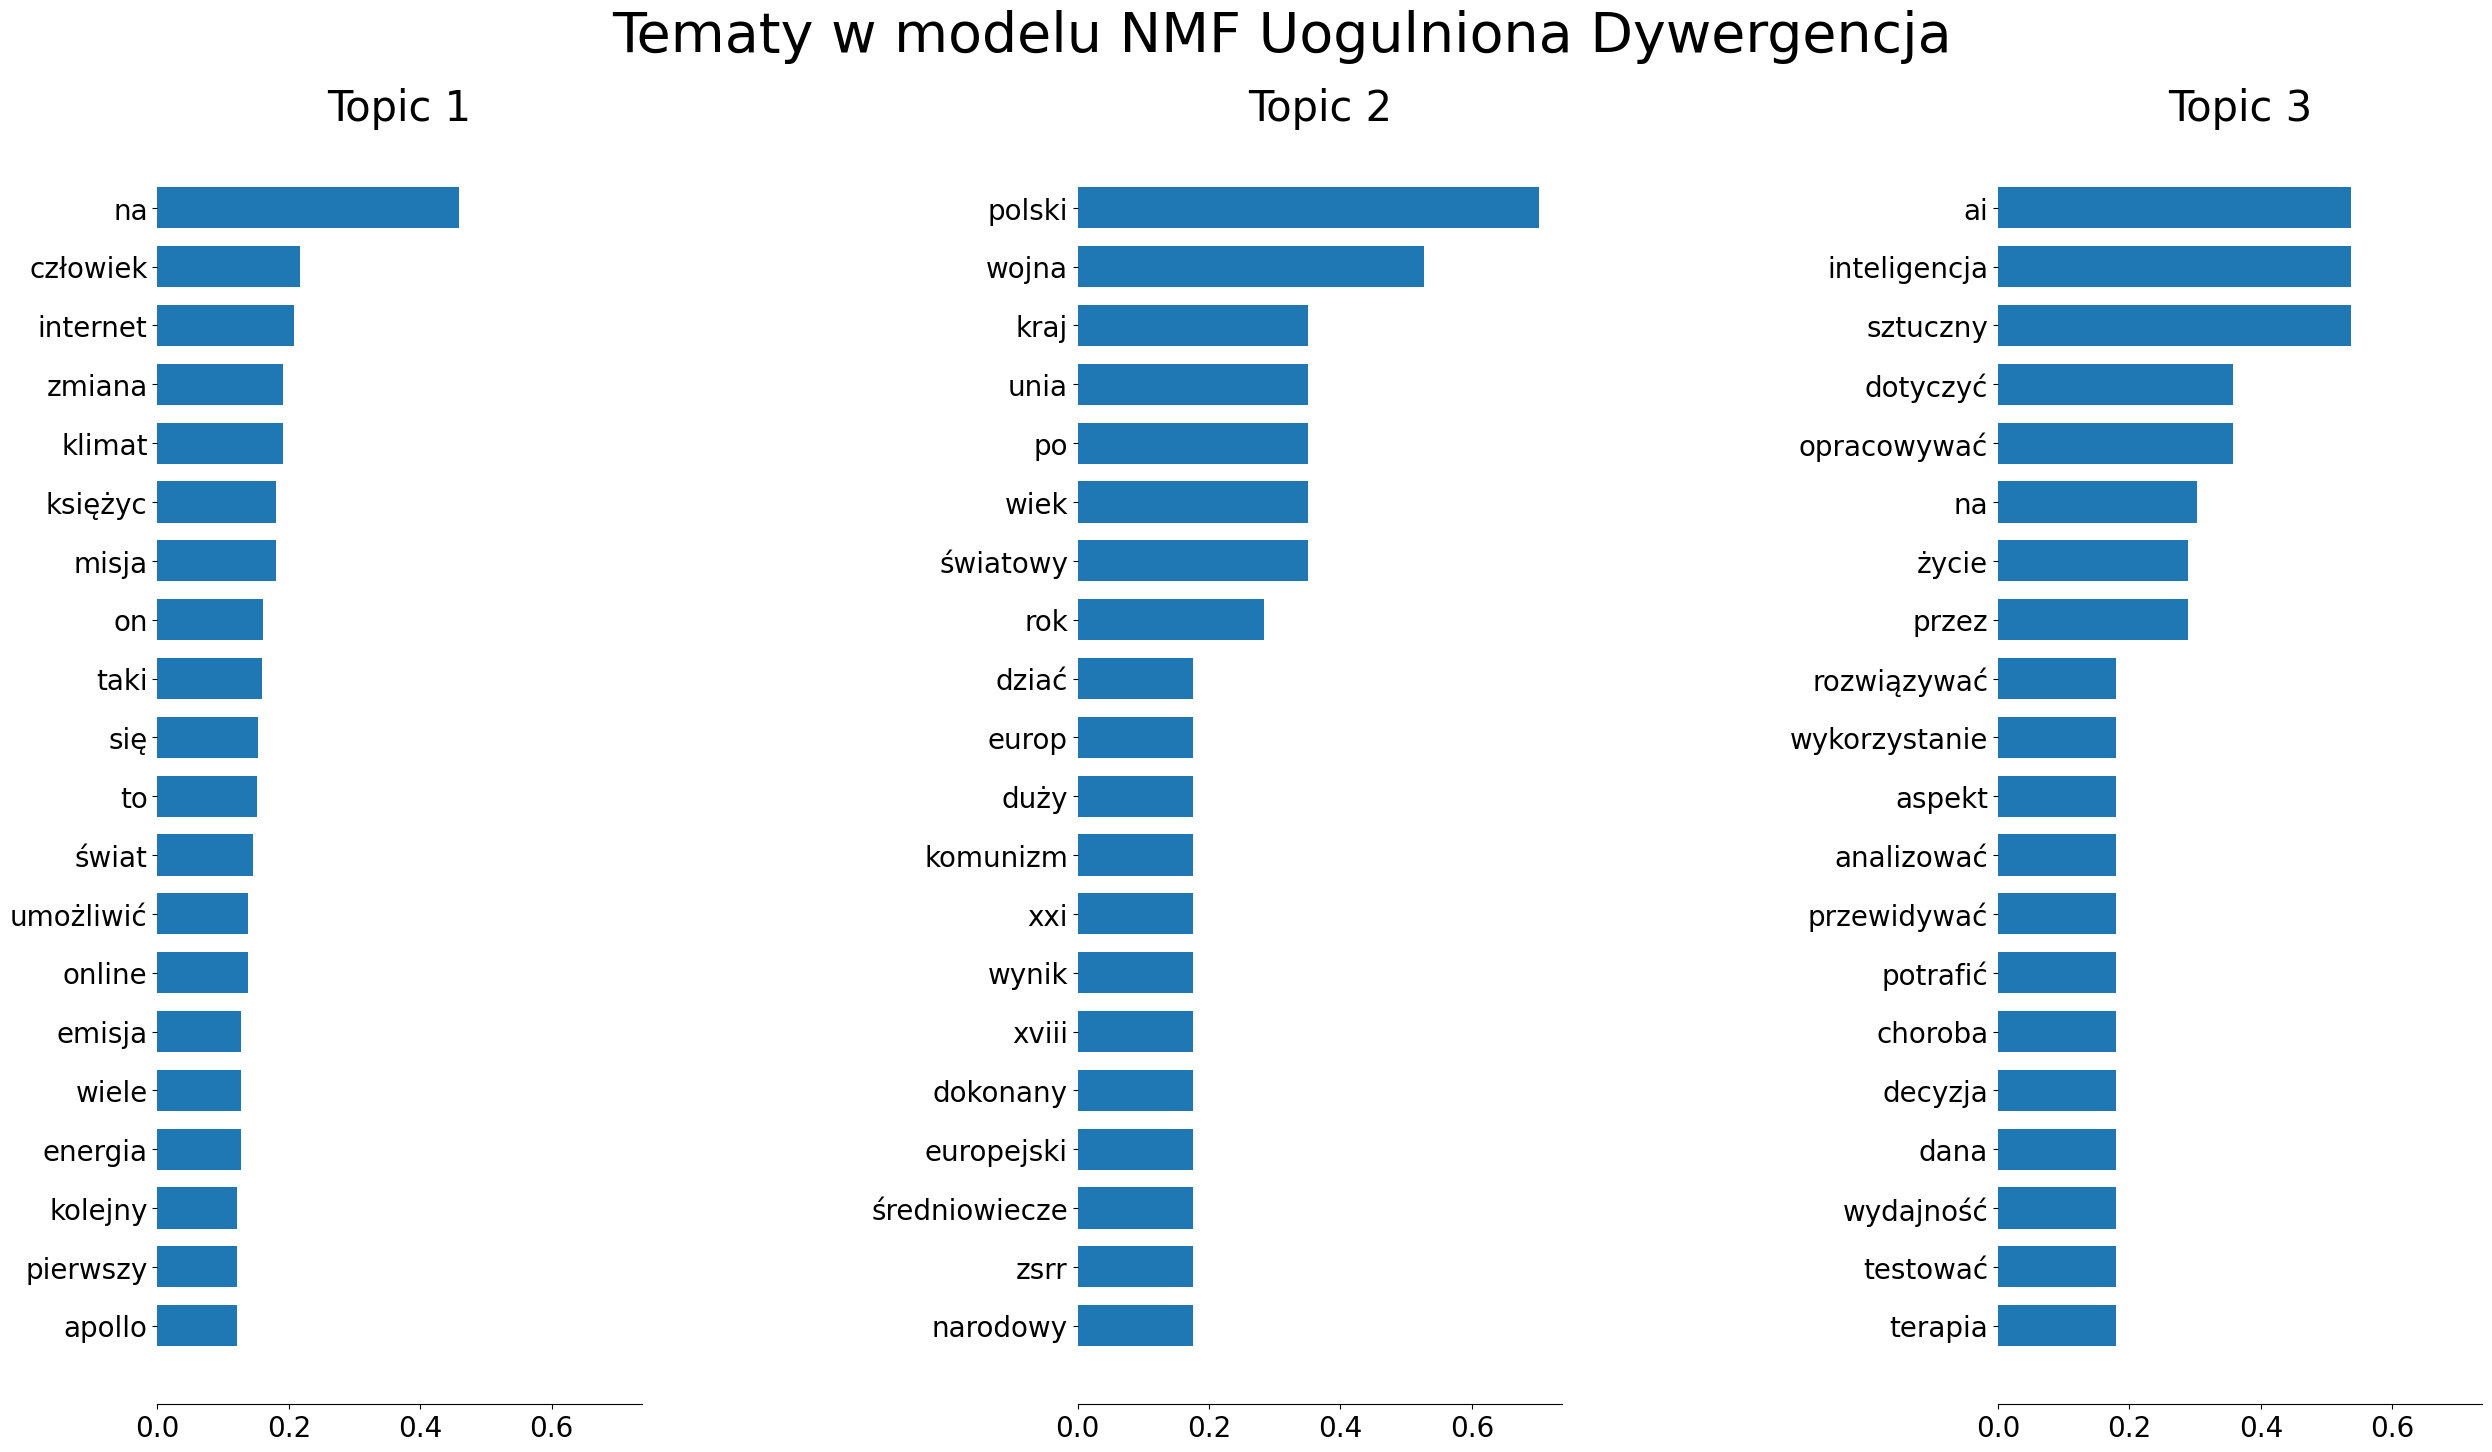

In [53]:
nmf_kl = NMF(
    n_components = n_components,
    random_state = 1, 
    beta_loss = 'kullback-leibler',
    solver = 'mu',
    max_iter = 1000,
    alpha_H = .00005,
    alpha_W = .00005,
    l1_ratio = .5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF Uogulniona Dywergencja", size)

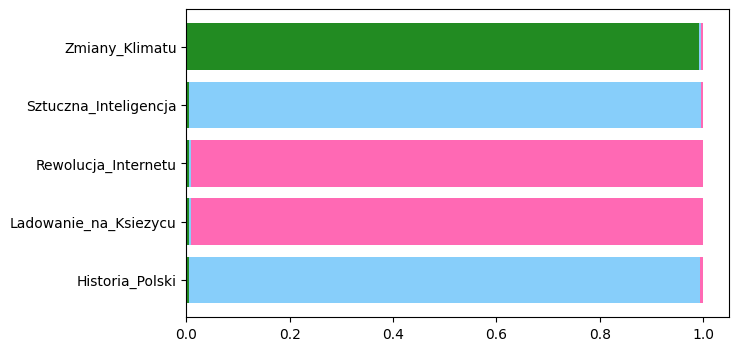

In [54]:
docs_topics = pd.DataFrame(lda.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

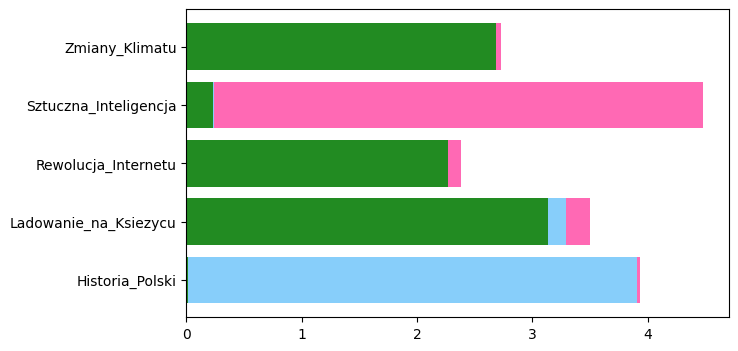

In [55]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize = (7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

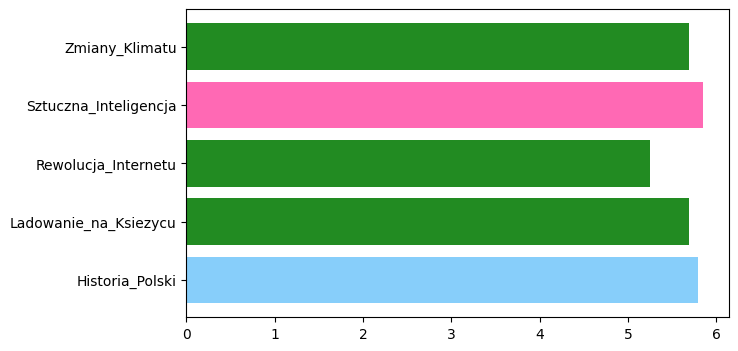

In [56]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3'])
docs_topics.index = [file_name.replace(".txt", "") for file_name in file_names]
plt.figure(figsize = (7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left = left, label = col, color = colors[i])
    left=[left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]

# Analiza skupień

In [57]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [58]:
n_docs = len(file_names)
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(n_docs, n_docs)
cs

array([[1.        , 0.04961531, 0.01751975, 0.02292538, 0.00976877],
       [0.04961531, 1.        , 0.10251833, 0.08356327, 0.12664283],
       [0.01751975, 0.10251833, 1.        , 0.07295953, 0.08790172],
       [0.02292538, 0.08356327, 0.07295953, 1.        , 0.06280028],
       [0.00976877, 0.12664283, 0.08790172, 0.06280028, 1.        ]])

In [59]:
clusering = AgglomerativeClustering(
    n_clusters = 3,
    metric = "euclidean",
    linkage = "ward",
    compute_distances = True
).fit(cs)
clusering.labels_

array([1, 0, 0, 2, 0])

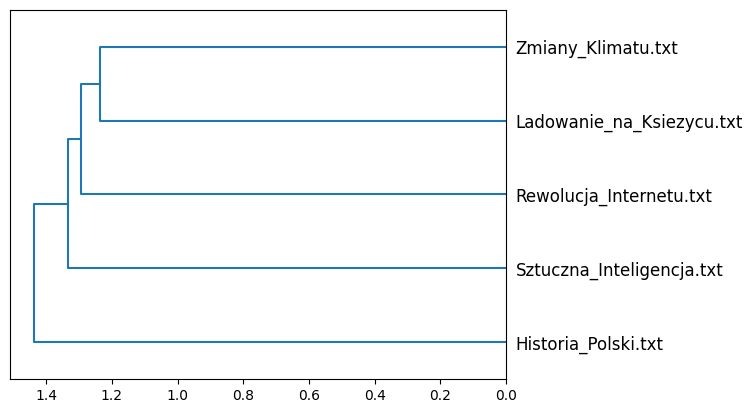

In [60]:
plot_dendrogram(
    clusering,
    labels = file_names,
    truncate_mode = 'level',
    orientation = 'left'
)
plt.show()

In [61]:
n_docs = len(file_names)
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(n_docs, n_docs)
ed

array([[ 0.        , 15.90597372, 14.07124728, 14.45683229, 14.73091986],
       [15.90597372,  0.        , 14.86606875, 15.16575089, 14.76482306],
       [14.07124728, 14.86606875,  0.        , 13.74772708, 13.67479433],
       [14.45683229, 15.16575089, 13.74772708,  0.        , 14.28285686],
       [14.73091986, 14.76482306, 13.67479433, 14.28285686,  0.        ]])

In [62]:
clusering = AgglomerativeClustering(
    n_clusters = 3,
    metric = "precomputed",
    linkage = "complete",
    compute_distances = True
).fit(ed)
clusering.labels_

array([2, 1, 0, 0, 0])

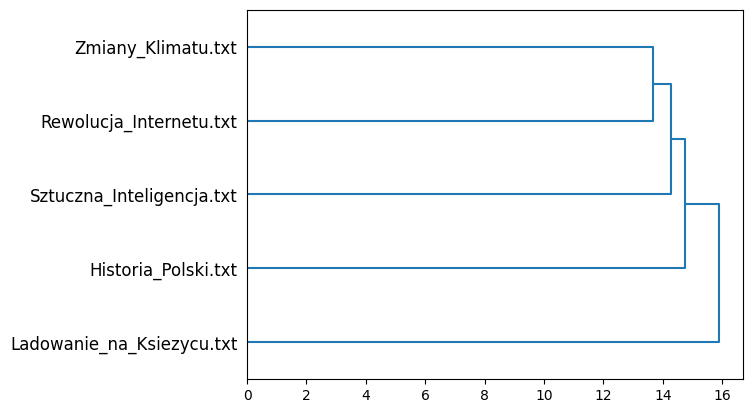

In [63]:
plot_dendrogram(
    clusering,
    labels = file_names,
    truncate_mode = 'level',
    orientation = 'right'
)
plt.show()

# N-gramy

In [64]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language = 'polish')
print(json.dumps(documents_tokenized, indent = 4, ensure_ascii = False))  

{
    "Historia_Polski.txt": [
        "historia",
        "polski",
        "bogaty",
        "pełny",
        "przełomowy",
        "wydarzenie",
        "w",
        "średniowiecze",
        "kraj",
        "rządzić",
        "piast",
        "Jagiellon",
        "unia",
        "z",
        "litwa",
        "stworzyć",
        "z",
        "duży",
        "państwo",
        "europ",
        "w",
        "XVIII",
        "wiek",
        "polski",
        "utracić",
        "niepodległość",
        "w",
        "wynik",
        "rozbiór",
        "dokonany",
        "przez",
        "sąsiad",
        "po",
        "wojna",
        "światowy",
        "krajać",
        "odzyskać",
        "suwerenność",
        "w",
        "rok",
        "ii",
        "wojna",
        "światowy",
        "przynieść",
        "ogromny",
        "strata",
        "cierpienie",
        "po",
        "wojna",
        "polski",
        "znaleźć",
        "się",
        "w",
        "strefa",
        "wpły

Historia_Polski.txt


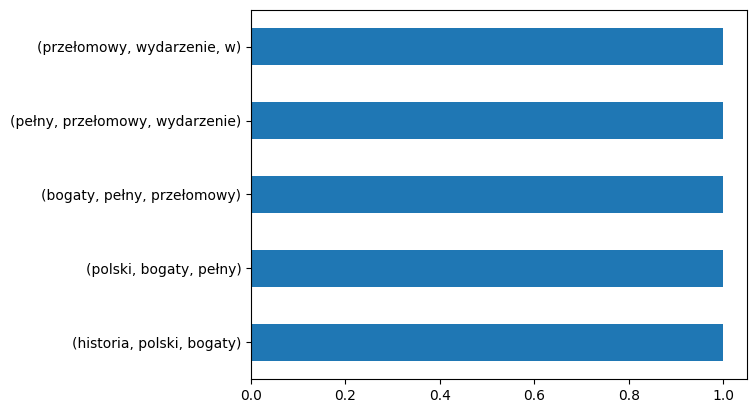

Ladowanie_na_Ksiezycu.txt


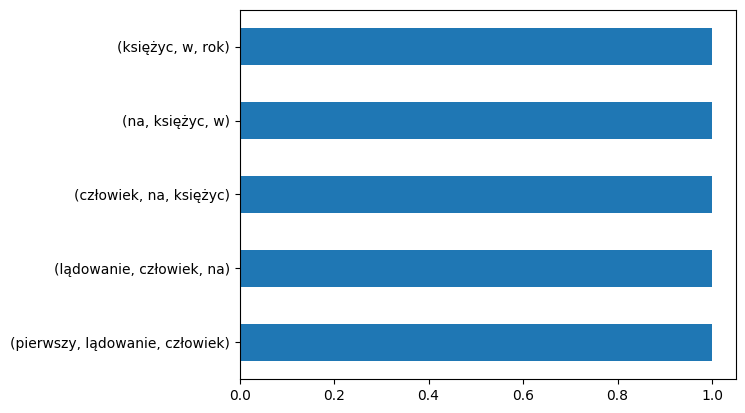

Rewolucja_Internetu.txt


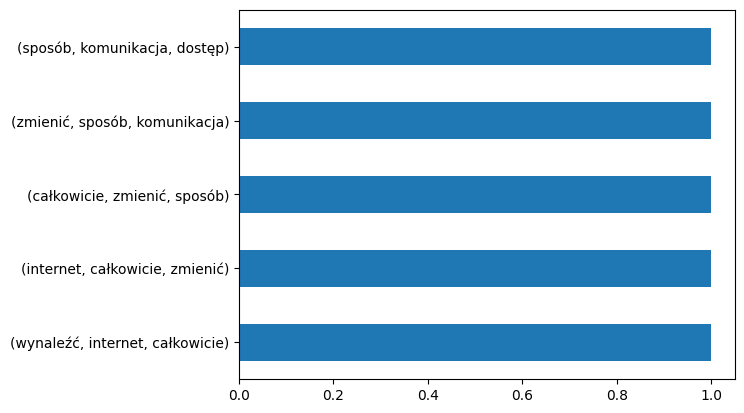

Sztuczna_Inteligencja.txt


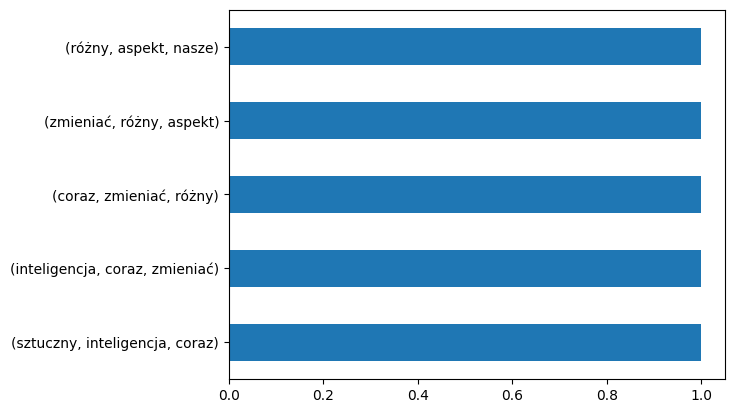

Zmiany_Klimatu.txt


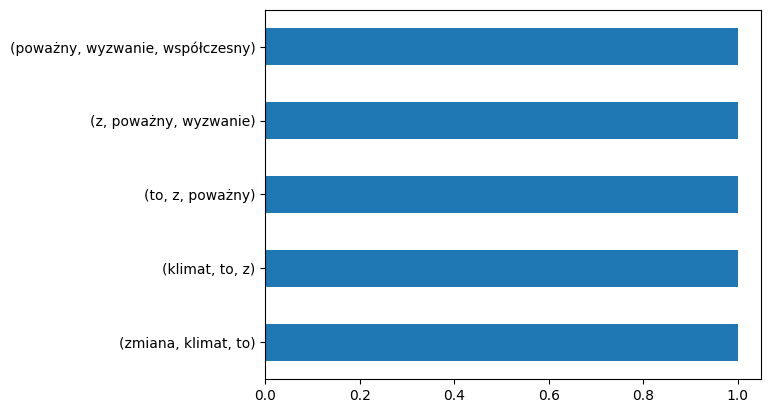

In [65]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 3)).value_counts()
    print(title)
    n_gram[:5].plot.barh()
    plt.show()

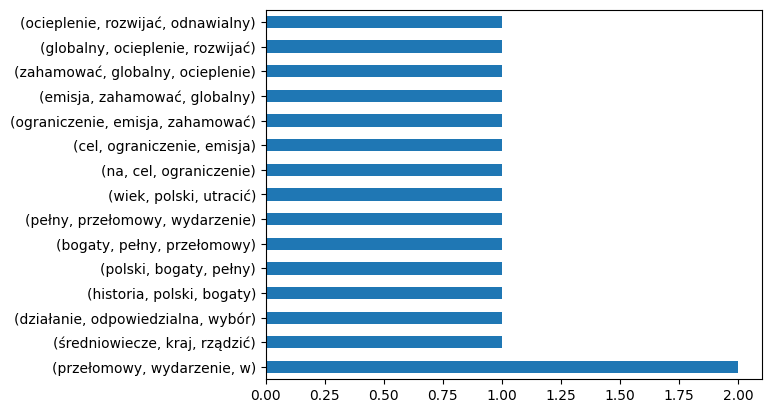

In [66]:
texts = ' '.join(docs['content']).split(" ")
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()